In [138]:
from leader_data import *
home_dir = os.path.abspath("..")  # Move up to the home directory
sys.path.append(home_dir)
from frengression import *
device = torch.device('cpu')

import numpy as np
import pandas as pd
import pickle
import os
from tqdm import tqdm
import torch.nn as nn
from copy import deepcopy

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

np.random.seed(42)


read data

In [217]:
df_bsl_read=generate_bsl()
df_bsl_read.dropna(inplace=True)
df_outcome=generate_outcome()
df_outcome

df_Y_read = df_outcome[['USUBJID'] + [f'Y{i}' for i in range(1, 11)]]
df_I = df_outcome[['USUBJID'] + [f'I{i}' for i in range(1, 11)]]
df_D = df_outcome[['USUBJID'] + [f'D{i}' for i in range(1, 11)]]
df_egfr, df_hba1c, df_bmi = generate_longi_cov()
df_Y_read

,USUBJID,Y1,Y2,Y3,Y4,Y5,Y6,Y7,Y8,Y9,Y10
1,EX2211-3748/5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,EX2211-3748/9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,EX2211-3748/16,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN
4,EX2211-3748/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,EX2211-3748/62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
9336,EX2211-3748/99915,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9337,EX2211-3748/99921,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9338,EX2211-3748/99929,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9339,EX2211-3748/99971,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [218]:
# number of events happened
ones_count = (df_Y_read.drop(columns=['USUBJID']) == 1).sum().sum()
ones_count

1302

In [219]:
df_hba1c

,USUBJID,0,12,18,24,3,30,36,42,48,54,6,60,1,61
1,EX2211-3748/10012,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,NaN,NaN
2,EX2211-3748/10023,7.6,6.0,6.3,6.0,6.3,6.1,6.4,6.8,6.5,6.5,6.3,7.3,NaN,NaN
3,EX2211-3748/10028,9.9,9.5,7.9,9.6,8.4,9.2,9.9,9.6,9.6,9.6,8.6,9.6,NaN,NaN
4,EX2211-3748/10034,9.6,9.6,9.5,9.3,9.6,7.0,6.0,6.0,6.0,6.0,10.9,6.3,NaN,NaN
5,EX2211-3748/10050,7.5,7.8,8.9,8.7,8.0,8.5,8.1,8.1,8.1,8.1,6.3,9.6,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9336,EX2211-3748/99915,7.1,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,NaN,NaN
9337,EX2211-3748/99921,8.6,6.5,6.6,6.6,6.0,6.5,7.0,7.0,7.0,7.0,6.1,6.3,NaN,NaN
9338,EX2211-3748/99929,7.3,7.0,7.0,7.0,6.9,7.0,7.0,7.0,7.0,7.0,6.9,7.0,NaN,NaN
9339,EX2211-3748/99971,10.5,8.3,10.0,11.1,9.8,10.0,9.4,9.7,9.7,9.7,9.7,10.7,8.9,NaN


In [220]:
df_bmi

,USUBJID,0,12,24,36,48,6,60
1,EX2211-3748/10012,31.6,31.6,31.6,31.6,31.6,31.6,31.6
2,EX2211-3748/10023,39.0,37.3,37.3,38.2,39.5,38.5,39.9
3,EX2211-3748/10028,30.8,30.7,30.4,29.3,29.3,30.6,30.1
4,EX2211-3748/10034,41.4,42.6,41.7,30.4,30.4,41.9,29.5
5,EX2211-3748/10050,50.8,48.8,45.8,45.2,45.2,45.1,44.7
...,...,...,...,...,...,...,...,...
9327,EX2211-3748/99915,37.5,37.5,37.5,37.5,37.5,37.5,37.5
9328,EX2211-3748/99921,33.7,31.4,33.3,33.4,33.4,31.1,33.1
9329,EX2211-3748/99929,27.0,27.8,27.8,27.8,27.8,28.4,27.8
9330,EX2211-3748/99971,28.0,31.3,29.9,29.7,29.7,29.7,29.6


In [221]:
df_egfr

,USUBJID,0,12,24,36,48,6,60,61,30,42,1,18,3,54
1,EX2211-3748/10012,96.7,96.7,96.7,96.7,96.7,96.7,96.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,EX2211-3748/10023,84.3,89.5,91.2,86.8,84.3,91.2,84.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,EX2211-3748/10028,84.4,77.1,70.0,88.5,88.5,78.3,76.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,EX2211-3748/10034,75.5,91.0,83.3,78.0,78.0,79.2,92.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,EX2211-3748/10050,75.7,90.0,59.0,42.3,42.3,100.6,65.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9336,EX2211-3748/99915,79.8,79.8,79.8,79.8,79.8,79.8,79.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9337,EX2211-3748/99921,93.1,94.2,93.6,81.4,81.4,96.9,77.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9338,EX2211-3748/99929,105.1,107.0,107.0,107.0,107.0,93.6,107.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9339,EX2211-3748/99971,103.4,90.7,91.2,95.0,95.0,85.2,90.7,NaN,NaN,NaN,95.6,NaN,NaN,NaN


The longitudinal features are processed with these rules:
1. As hba1c has been measured several times, we use it as the benchmark for marking the records. However, we still discard month = 1 and month = 61 as there are not that many
2. Since egfr and bmi are measured less frequently, we impute the missing values using the observations in the previous visit time.
3. The simulated data will be evaluated by masking up intervals that the egfr and bmi are not recorded.

Also, we standardize continuous variables in baseline covariates and time varying covariates.

## pre-process data

In [222]:
import pandas as pd
import numpy as np
import torch
from copy import deepcopy
from sklearn.preprocessing import StandardScaler

# ------------------------- Load Your Data -------------------------
df_z1 = deepcopy(df_hba1c)   # longitudinal covariate z1
df_z2 = deepcopy(df_egfr)    # longitudinal covariate z2
df_z3 = deepcopy(df_bmi)     # longitudinal covariate z3
df_bsl = deepcopy(df_bsl_read)    # baseline covariates
df_Y = deepcopy(df_Y_read)        # outcome
df_bsl.dropna(inplace=True)
# df_bsl.drop(df_bsl[(df_bsl['TRIG1BL'] > 8) | (df_bsl['CREATBL'] > 160)].index, inplace=True)
# create the log-transformed columns
df_bsl['log_TRIG1BL'] = np.log(df_bsl['TRIG1BL'])
df_bsl['log_CREATBL'] = np.log(df_bsl['CREATBL'])

# drop the original columns
df_bsl.drop(['TRIG1BL', 'CREATBL'], axis=1, inplace=True)


# --------------------- Process df_Y (Outcome) ---------------------
# Ensure Y0 exists and select Y0 to Y10.
if 'Y0' not in df_Y.columns:
    df_Y.insert(1, 'Y0', 0.0)
df_Y = df_Y[['USUBJID'] + [f'Y{i}' for i in range(0, 11)]]

# (These are the actual numeric time values corresponding to Y0 ... Y10.)
time_points = [0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60]

def process_longitudinal(df, time_points):
    df = df.loc[:, ['USUBJID'] + [str(tp) for tp in time_points if str(tp) in df.columns]].copy()
    for tp in time_points:
        col = str(tp)
        if col not in df.columns:
            df.loc[:, col] = np.nan
    df = df.loc[:, ['USUBJID'] + [str(tp) for tp in time_points]]

    # df['na_count'] = df.isna().sum(axis=1)
    # df = df.loc[df['na_count'] <= 5].drop(columns='na_count').reset_index(drop=True)
    df = df.reset_index(drop=True)

    for idx in range(len(df)):
        for t_idx, t in enumerate(time_points):
            col = str(t)
            if pd.isna(df.loc[idx, col]):
                for prev_t in reversed(time_points[:t_idx]):
                    prev_col = str(prev_t)
                    if not pd.isna(df.loc[idx, prev_col]):
                        df.loc[idx, col] = df.loc[idx, prev_col]
                        break

    return df

# ------------- Process and Clean z1, z2, z3 ----------------
df_z1_clean = process_longitudinal(df_z1, time_points)
df_z2_clean = process_longitudinal(df_z2, time_points)
df_z3_clean = process_longitudinal(df_z3, time_points)


df_z1_clean = df_z1_clean.dropna(axis=0, how='any').reset_index(drop=True)
df_z2_clean = df_z2_clean.dropna(axis=0, how='any').reset_index(drop=True)
df_z3_clean = df_z3_clean.dropna(axis=0, how='any').reset_index(drop=True)

# ------------ Align All by Intersection of USUBJID -------------
common_ids = (set(df_Y['USUBJID']) 
              & set(df_z1_clean['USUBJID']) 
              & set(df_z2_clean['USUBJID']) 
              & set(df_z3_clean['USUBJID']) 
              & set(df_bsl['USUBJID']))
df_Y = df_Y[df_Y['USUBJID'].isin(common_ids)].reset_index(drop=True)
df_z1_clean = df_z1_clean[df_z1_clean['USUBJID'].isin(common_ids)].reset_index(drop=True)
df_z2_clean = df_z2_clean[df_z2_clean['USUBJID'].isin(common_ids)].reset_index(drop=True)
df_z3_clean = df_z3_clean[df_z3_clean['USUBJID'].isin(common_ids)].reset_index(drop=True)
df_bsl = df_bsl[df_bsl['USUBJID'].isin(common_ids)].reset_index(drop=True)


for D in (df_Y, df_z1_clean, df_z2_clean, df_z3_clean, df_bsl):
    D.sort_values('USUBJID', inplace=True)
    D.reset_index(drop=True, inplace=True)

cols = [str(tp) for tp in time_points]

for df in (df_z1_clean, df_z2_clean, df_z3_clean):
    # compute per-column mean & std, skipping NaNs
    means = df[cols].mean(skipna=True)
    stds  = df[cols].std(skipna=True)

    # subtract mean, divide by std; NaNs remain NaN
    df[cols] = (df[cols] - means) / stds

# ----------------- Build the Z torch tensor (longitudinal) ----------------------

Z_list = []
for idx in range(len(df_z1_clean)):
    z1_vals = df_z1_clean.iloc[idx][[str(tp) for tp in time_points]].astype(float).values
    z2_vals = df_z2_clean.iloc[idx][[str(tp) for tp in time_points]].astype(float).values
    z3_vals = df_z3_clean.iloc[idx][[str(tp) for tp in time_points]].astype(float).values

    Z_subj = np.column_stack([z1_vals, z2_vals, z3_vals]).reshape(-1)
    Z_list.append(Z_subj.astype(np.float32))

z_tensor = torch.tensor(np.vstack(Z_list), dtype=torch.float32)  # Shape (n_subjects, len(time_points))
# ----------------- Build the X tensor (ARM repeated over time) -------------------
# Pull ARM values from df_bsl; assume 'ARM' is a column.
arm_values = df_bsl['ARM'].astype(float).values  # shape (n_subjects,)
x_tensor = torch.tensor(np.repeat(arm_values[:, np.newaxis], len(time_points), axis=1), dtype=torch.int32)
# ------------------ Build the y torch tensor ----------------------
y_cols = [f'Y{i}' for i in range(0, 11)]
y_np = df_Y[y_cols].astype(float).values  # Ensure it's float so that NaN is preserved
y_tensor = torch.tensor(y_np, dtype=torch.int32)
# ----------------- Build the S tensor (baseline features) -------------------
df_bsl_features = df_bsl.drop(columns=['USUBJID','ARM',  
    'RACE_AMERICAN.INDIAN.OR.ALASKA.NATIVE',
    'RACE_NATIVE.HAWAIIAN.OR.OTHER.PACIFIC.ISLANDER',
    'RACE_OTHER',
    'RACE_ASIAN',
    'RACE_BLACK.OR.AFRICAN.AMERICAN',"HBA1CBL","BMIBL", 'SMOKER_CURRENT.SMOKER',
    "STROKEFL",	
     'KIDFL',
      'MIFL',	
    # "STENFL",
    # #"AGE", 
    # "DIABDUR",
    #"HDL1BL",	"LDL1BL",	
    # "CHOL1BL",	
    #"TRIG1BL", 
    # "CREATBL"
    ])

binary_cols     = ['SEX_F', 'SMOKER_NEVER.SMOKED',"STENFL",'NEPSCRFL'] 
continuous_cols = [c for c in df_bsl_features.columns
                   if c not in binary_cols]

# 2. Scale the continuous ones to zero‑mean, unit‑variance
scaler = StandardScaler()
df_bsl_cont = pd.DataFrame(
    scaler.fit_transform(df_bsl[continuous_cols]),
    columns=continuous_cols,
    index=df_bsl.index
)

df_bsl_norm = pd.concat([df_bsl_features[binary_cols],df_bsl_cont], axis=1)

df_bsl_features = df_bsl_features.astype(float)
x_bsl_tensor = torch.tensor(df_bsl['ARM'].values, dtype=torch.int32).view(-1, 1)
# s_tensor = torch.tensor(df_bsl_features.values, dtype=torch.float32)
s_tensor = torch.tensor(df_bsl_norm.astype(float).values, dtype=torch.float32)

# ----------------- Check shape -------------------
print(f"s_tensor shape: {s_tensor.shape}")  # (n_subjects, num_baseline_features)
print(f"z_tensor shape: {z_tensor.shape}")  # (n_subjects, {len(time_points)}) 
print(f"x_tensor shape (ARM): {x_tensor.shape}")  # (n_subjects, 11)
print(f"y_tensor shape: {y_tensor.shape}")  # (n_subjects, 11)

# Optional: Sanity check USUBJID order alignment.
print(np.all(df_Y['USUBJID'].values == df_z1_clean['USUBJID'].values))
print(np.all(df_Y['USUBJID'].values == df_bsl['USUBJID'].values))
print(torch.isnan(y_tensor).any())  # Returns True if any NaN exists

# Optional: Count the number of 1's in a DataFrame.
# For example, to count total number of 1s in df_Y (excluding the USUBJID column):
ones_count = (df_Y.drop(columns=['USUBJID']) == 1).sum().sum()
print("Total number of 1s in df_Y:", ones_count)


s_tensor shape: torch.Size([9161, 11])
z_tensor shape: torch.Size([9161, 33])
x_tensor shape (ARM): torch.Size([9161, 11])
y_tensor shape: torch.Size([9161, 11])
True
True
tensor(False)
Total number of 1s in df_Y: 1267


In [66]:
p = s_tensor.shape[1]
print(f'number of covariates: {p}')
binary_intervention = True
torch.manual_seed(42)

number of covariates: 11


In [32]:
p = s_tensor.shape[1]
print(f'number of covariates: {p}')
binary_intervention = True
torch.manual_seed(42)
model_bsl = Frengression(x_bsl_tensor.shape[1], y_tensor.shape[1], s_tensor.shape[1], noise_dim=1, num_layer=3, hidden_dim=100, device=device, x_binary = binary_intervention, z_binary_dims=4)
model_bsl.train_xz(x_bsl_tensor, s_tensor, num_iters=15000, lr=5e-4, print_every_iter=1000)

number of covariates: 11
Epoch 1: loss 2.6210, loss1 2.7477, loss2 0.2533
Epoch 1000: loss 1.9264, loss1 3.8329, loss2 3.8129
Epoch 2000: loss 1.9287, loss1 3.8446, loss2 3.8317
Epoch 3000: loss 1.9309, loss1 3.8346, loss2 3.8075
Epoch 4000: loss 1.9393, loss1 3.8497, loss2 3.8208
Epoch 5000: loss 1.9368, loss1 3.8539, loss2 3.8343
Epoch 6000: loss 1.9210, loss1 3.8417, loss2 3.8416
Epoch 7000: loss 1.9393, loss1 3.8629, loss2 3.8473
Epoch 8000: loss 1.9207, loss1 3.8436, loss2 3.8458
Epoch 9000: loss 1.9213, loss1 3.8515, loss2 3.8603
Epoch 10000: loss 1.9353, loss1 3.8423, loss2 3.8140
Epoch 11000: loss 1.9387, loss1 3.8556, loss2 3.8337
Epoch 12000: loss 1.9295, loss1 3.8503, loss2 3.8417
Epoch 13000: loss 1.9276, loss1 3.8352, loss2 3.8150
Epoch 14000: loss 1.9241, loss1 3.8421, loss2 3.8362
Epoch 15000: loss 1.9249, loss1 3.8605, loss2 3.8712


In [55]:
model_bsl.train_xz(x_bsl_tensor, s_tensor, num_iters=5000, lr=1e-4, print_every_iter=1000)

Epoch 1: loss 1.9311, loss1 3.8660, loss2 3.8698
Epoch 1000: loss 1.9425, loss1 3.8739, loss2 3.8628
Epoch 2000: loss 1.9305, loss1 3.8444, loss2 3.8279
Epoch 3000: loss 1.9217, loss1 3.8526, loss2 3.8618
Epoch 4000: loss 1.9126, loss1 3.8376, loss2 3.8500
Epoch 5000: loss 1.9257, loss1 3.8564, loss2 3.8615


In [4]:
# torch.save(model_bsl,"results/model_bsl_logcov.pt")
model_bsl = torch.load("results/model_bsl_logcov.pt")

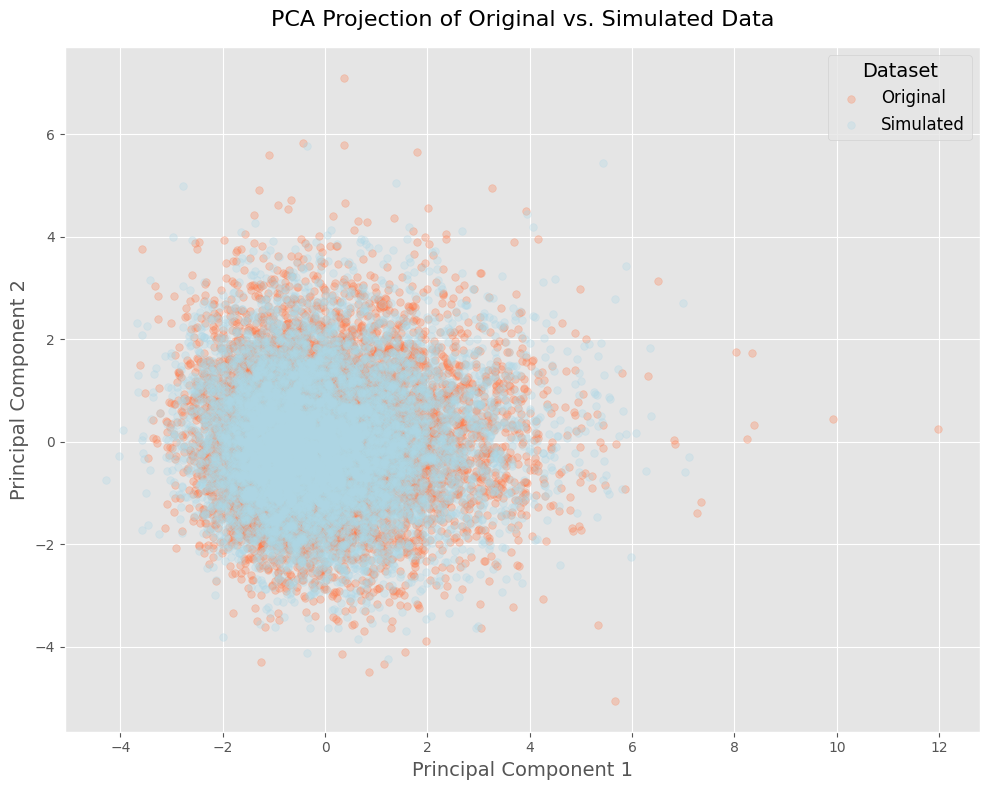

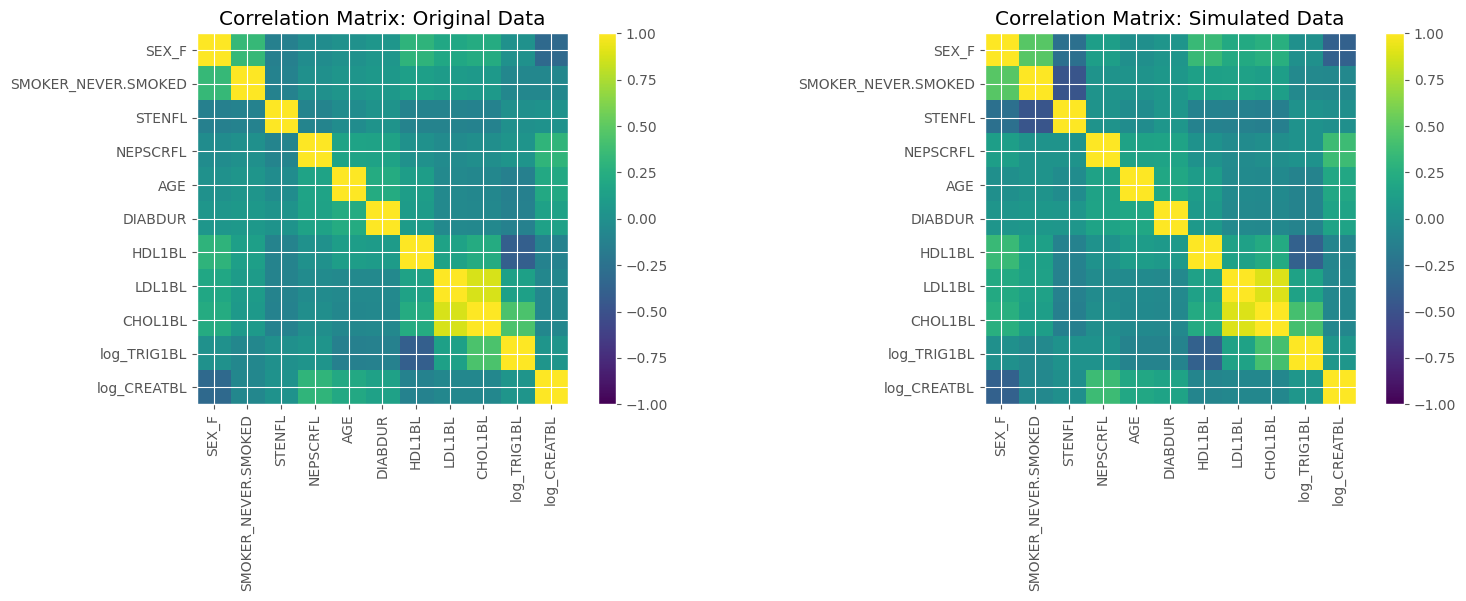

Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.49      0.49      2749
           1       0.49      0.48      0.48      2748

    accuracy                           0.49      5497
   macro avg       0.49      0.49      0.49      5497
weighted avg       0.49      0.49      0.49      5497

Accuracy: 0.49
ROC AUC: 0.48


In [56]:
x,s_pred=model_bsl.sample_xz(sample_size=s_tensor.shape[0])

original_df = deepcopy(df_bsl_norm)
simulated_df = pd.DataFrame(s_pred.numpy())
simulated_df.columns = original_df.columns
original_df ['source'] = 'original'
simulated_df['source'] = 'simulated'
# original_df.drop(columns={'USUBJID'},inplace=True)
combined_df = pd.concat([original_df, simulated_df], ignore_index=True)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

original_df['source'] = 'Original'
simulated_df['source'] = 'Simulated'

combined_df = pd.concat([original_df, simulated_df], ignore_index=True)
features = combined_df.drop(columns='source')
labels = combined_df['source']

# --- PCA Transformation ---
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features)
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
pca_df['source'] = labels.values

style = 'seaborn' if 'seaborn' in plt.style.available else 'ggplot'
plt.style.use(style)

fig, ax = plt.subplots(figsize=(10, 8))


colors = {'Original': 'coral', 'Simulated': 'lightblue'}

for group in pca_df['source'].unique():
    group_data = pca_df[pca_df['source'] == group]
    ax.scatter(group_data['PC1'], group_data['PC2'],
               s=30, alpha=0.3, label=group, color=colors[group])

ax.set_title('PCA Projection of Original vs. Simulated Data', fontsize=16, pad=15)
ax.set_xlabel('Principal Component 1', fontsize=14)
ax.set_ylabel('Principal Component 2', fontsize=14)

ax.legend(title='Dataset', fontsize=12, title_fontsize=14, loc='best')

plt.tight_layout()
plt.show()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# ---------------------------
# 1. Population Summary Comparison
# ---------------------------
# Compute mean values for each covariate
original_df.drop(columns={'source'},inplace=True)
simulated_df.drop(columns={'source'},inplace=True)
mean_original = original_df.mean()
mean_simulated = simulated_df.mean()

# Create a grouped bar chart comparing means
x = np.arange(len(mean_original))  # positions for each covariate
width = 0.35  # width of the bars

# plt.style.use('ggplot')  # Use a beautiful built-in style
# fig, ax = plt.subplots(figsize=(12, 6))
# rects1 = ax.bar(x - width/2, mean_original, width, label='Original')
# rects2 = ax.bar(x + width/2, mean_simulated, width, label='Simulated')

# ax.set_xticks(x)
# ax.set_xticklabels(original_df.columns, rotation=45, ha='right')
# ax.set_ylabel('Mean Value')
# ax.set_title('Comparison of Mean Values by Covariate')
# ax.legend()
# plt.tight_layout()
# plt.show()


corr_original = original_df.corr()
corr_simulated = simulated_df.corr()

# Create two heatmaps side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Heatmap for original data
im0 = axes[0].imshow(corr_original, cmap='viridis', vmin=-1, vmax=1)
axes[0].set_title('Correlation Matrix: Original Data')
axes[0].set_xticks(np.arange(len(corr_original.columns)))
axes[0].set_xticklabels(corr_original.columns, rotation=90)
axes[0].set_yticks(np.arange(len(corr_original.columns)))
axes[0].set_yticklabels(corr_original.columns)
plt.colorbar(im0, ax=axes[0])

# Heatmap for simulated data
im1 = axes[1].imshow(corr_simulated, cmap='viridis', vmin=-1, vmax=1)
axes[1].set_title('Correlation Matrix: Simulated Data')
axes[1].set_xticks(np.arange(len(corr_simulated.columns)))
axes[1].set_xticklabels(corr_simulated.columns, rotation=90)
axes[1].set_yticks(np.arange(len(corr_simulated.columns)))
axes[1].set_yticklabels(corr_simulated.columns)
plt.colorbar(im1, ax=axes[1])

plt.tight_layout()
plt.show()


orig = original_df.copy()
sim = simulated_df.copy()

orig['label'] = 0
sim['label'] = 1

# Combine the datasets
combined_df = pd.concat([orig, sim], ignore_index=True)

# Separate features and target
X = combined_df.drop(columns=['label'])
y = combined_df['label']

# Split into training and testing sets (stratified to maintain label balance)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Train a logistic regression classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Get predictions and predicted probabilities for AUC calculation
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

print("Classification Report:")
print(report)
print("Accuracy: {:.2f}".format(accuracy))
print("ROC AUC: {:.2f}".format(auc))

# If the two datasets are very similar, even a strong classifier should perform poorly
# (accuracy near 50% and AUC near 0.5), indicating that it is difficult to tell them apart.


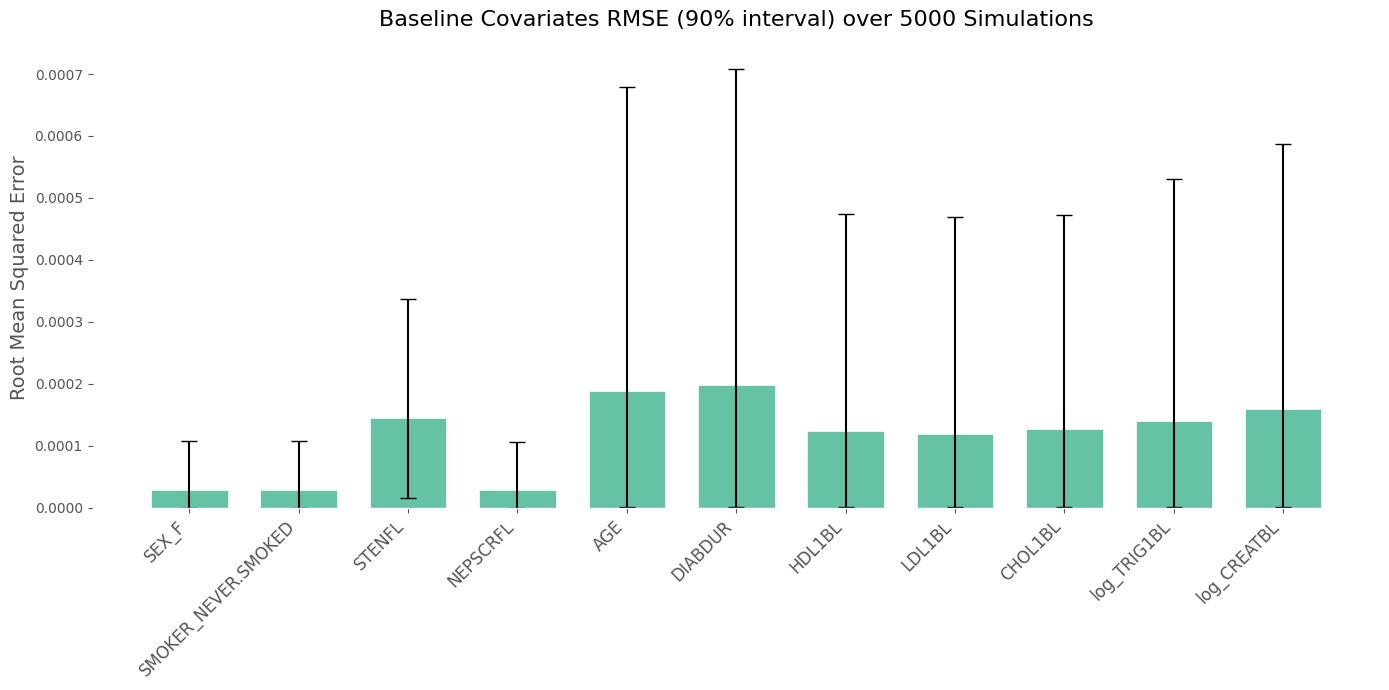

Accuracy:  μ=0.489, σ=0.009, [0.437–0.524]
AUC:       μ=0.489, σ=0.007, [0.464–0.520]


In [63]:

num_simulations = 5000
accuracy_list, auc_list = [], []
covariate_squared_errors = []

original_df = deepcopy(df_bsl_norm)
orig_cov_means = original_df.mean()
for i in range(num_simulations):
    # simulate as before...
    x_sim, s_pred = model_bsl.sample_xz(sample_size=s_tensor.shape[0])
    simulated_df = pd.DataFrame(
        s_pred.detach().cpu().numpy(),
        columns=original_df.columns
    )
    
    # classification performance ...
    combined = pd.concat([original_df, simulated_df], ignore_index=True)
    X = combined; y = np.concatenate([np.zeros(len(original_df)), np.ones(len(simulated_df))])
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    clf = LogisticRegression(max_iter=1000).fit(X_train, y_train)
    pred = clf.predict(X_test); proba = clf.predict_proba(X_test)[:,1]
    accuracy_list.append(accuracy_score(y_test, pred))
    auc_list.append(roc_auc_score(y_test, proba))
    
    # **raw** MSE per covariate
    sim_means = simulated_df.mean()
    raw_mse = (sim_means - orig_cov_means)**2
    covariate_squared_errors.append(raw_mse)

mse_df = pd.DataFrame(covariate_squared_errors)

# quantiles
mse_mean = mse_df.mean()
qs = mse_df.quantile([0.05, 0.95])
lower_err = mse_mean - qs.loc[0.05]
upper_err = qs.loc[0.95] - mse_mean
yerr = np.vstack([lower_err, upper_err])

# plot
cmap = plt.get_cmap('Set2')
single_color = cmap(0)   # index 2 is the 3rd color in Set2

# --- plot with that color for every bar ---
fig, ax = plt.subplots(figsize=(14, 7))
bars = ax.bar(
    x, mse_mean,
    yerr=yerr,
    capsize=6,
    width=0.7,
    color=single_color,
    edgecolor='white'
)

ax.set_facecolor('white')
fig.patch.set_facecolor('white')
ax.grid(axis='y', linestyle='--', alpha=0.6)
for spine in ['top','right','left']:
    ax.spines[spine].set_visible(False)

ax.set_xticks(x)
ax.set_xticklabels(mse_mean.index, rotation=45, ha='right', fontsize=12)
ax.set_ylabel('Root Mean Squared Error', fontsize=14)
ax.set_title(
    f'Baseline Covariates RMSE (90% interval) over {num_simulations} Simulations',
    fontsize=16, pad=15
)

plt.tight_layout()
plt.show()

# --- 4) Summary of classification performance -------------------------------
print(f"Accuracy:  μ={np.mean(accuracy_list):.3f}, σ={np.std(accuracy_list, ddof=1):.3f}, "
      f"[{np.min(accuracy_list):.3f}–{np.max(accuracy_list):.3f}]")
print(f"AUC:       μ={np.mean(auc_list):.3f}, σ={np.std(auc_list, ddof=1):.3f}, "
      f"[{np.min(auc_list):.3f}–{np.max(auc_list):.3f}]")


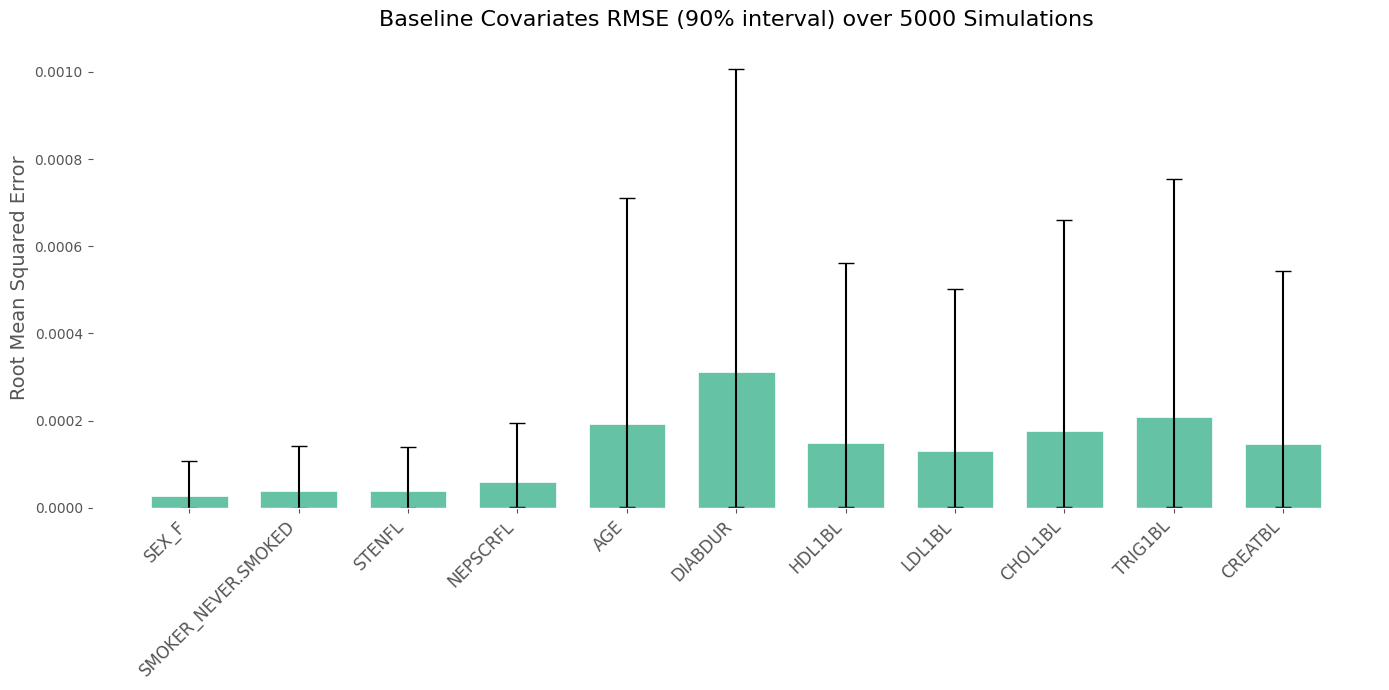

Accuracy:  μ=0.497, σ=0.007, [0.462–0.522]
AUC:       μ=0.496, σ=0.006, [0.470–0.520]


In [14]:
mse_df = pd.DataFrame(covariate_squared_errors)

# quantiles
mse_mean = mse_df.mean()
qs = mse_df.quantile([0.05, 0.95])
lower_err = mse_mean - qs.loc[0.05]
upper_err = qs.loc[0.95] - mse_mean
yerr = np.vstack([lower_err, upper_err])

# plot
cmap = plt.get_cmap('Set2')
single_color = cmap(0)   # index 2 is the 3rd color in Set2

# --- plot with that color for every bar ---
fig, ax = plt.subplots(figsize=(14, 7))
bars = ax.bar(
    x, mse_mean,
    yerr=yerr,
    capsize=6,
    width=0.7,
    color=single_color,
    edgecolor='white'
)

ax.set_facecolor('white')
fig.patch.set_facecolor('white')
ax.grid(axis='y', linestyle='--', alpha=0.6)
for spine in ['top','right','left']:
    ax.spines[spine].set_visible(False)

ax.set_xticks(x)
ax.set_xticklabels(mse_mean.index, rotation=45, ha='right', fontsize=12)
ax.set_ylabel('Root Mean Squared Error', fontsize=14)
ax.set_title(
    f'Baseline Covariates RMSE (90% interval) over {num_simulations} Simulations',
    fontsize=16, pad=15
)

plt.tight_layout()
plt.show()

# --- 4) Summary of classification performance -------------------------------
print(f"Accuracy:  μ={np.mean(accuracy_list):.3f}, σ={np.std(accuracy_list, ddof=1):.3f}, "
      f"[{np.min(accuracy_list):.3f}–{np.max(accuracy_list):.3f}]")
print(f"AUC:       μ={np.mean(auc_list):.3f}, σ={np.std(auc_list, ddof=1):.3f}, "
      f"[{np.min(auc_list):.3f}–{np.max(auc_list):.3f}]")

In [64]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.model_selection import train_test_split

# ... (build combined_df with 'label' as before) ...

# Separate features and target
X = combined_df.drop(columns=['label'])
y = combined_df['label']

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=2025,
    stratify=y
)

# Train a Random Forest classifier
clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=3,
    random_state=42,
    n_jobs=-1
)
clf.fit(X_train, y_train)

# Predictions and probabilities
y_pred      = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
auc      = roc_auc_score(y_test, y_pred_proba)
report   = classification_report(y_test, y_pred)

print("Classification Report:")
print(report)
print(f"Accuracy: {accuracy:.2f}")
print(f"ROC AUC:  {auc:.2f}")


Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.93      0.67      2749
           1       0.69      0.16      0.26      2748

    accuracy                           0.54      5497
   macro avg       0.61      0.54      0.46      5497
weighted avg       0.61      0.54      0.46      5497

Accuracy: 0.54
ROC AUC:  0.64


## Train surv

In [67]:
torch.manual_seed(42)
model = FrengressionSurv(x_dim=1, y_dim=1, z_dim=3, T=11, s_dim = s_tensor.shape[1], noise_dim=1, num_layer=3, hidden_dim=100, 
                        device=device, x_binary = True, s_in_predict=True, y_binary=True)
model.train_e(s=s_tensor,x=x_tensor,z=z_tensor,y=y_tensor,num_iters=10000, lr=5e-3, print_every_iter=1000)
model.train_y(s=s_tensor,x=x_tensor,z=z_tensor,y=y_tensor,num_iters=10000, lr=5e-3, print_every_iter=1000,reg_lambda=1)

Epoch 1: loss 5.2674, loss1 5.3480, loss2 0.1613
Epoch 1000: loss 2.7532, loss1 5.3451, loss2 5.1837
Epoch 2000: loss 2.5609, loss1 4.9946, loss2 4.8675
Epoch 3000: loss 2.4581, loss1 4.8242, loss2 4.7323
Epoch 4000: loss 2.4110, loss1 4.6956, loss2 4.5691
Epoch 5000: loss 2.3542, loss1 4.5994, loss2 4.4905
Epoch 6000: loss 2.3175, loss1 4.5690, loss2 4.5030
Epoch 7000: loss 2.2889, loss1 4.5193, loss2 4.4609
Epoch 8000: loss 2.2629, loss1 4.4436, loss2 4.3614
Epoch 9000: loss 2.2527, loss1 4.3945, loss2 4.2836
Epoch 10000: loss 2.2331, loss1 4.3238, loss2 4.1814
Epoch 1: loss 51135926272.0000,	loss_y 1.6256, 1.6373, 0.0235,	loss_eta 3.1611, 3.2448, 0.1675, 	marginal_loss 51135926272.0000
Epoch 1: y_sample_mean 0.013406635262072086
Epoch 1: y_sample1_cat.float().mean() 0.4926789700984955
Epoch 1000: loss 10.2560,	loss_y 0.1644, 0.2196, 0.1106,	loss_eta 9.9076, 19.3333, 18.8512, 	marginal_loss 0.1839
Epoch 1000: y_sample_mean 0.013486023060977459
Epoch 1000: y_sample1_cat.float().mean()

In [68]:
model.train_xz(s=s_tensor, x=x_tensor, z=z_tensor, y=y_tensor, num_iters=40000, lr=1e-3, print_every_iter=1000)

Epoch 1: loss 5.5018, loss1 5.6314, loss2 0.2593
Epoch 1000: loss 1.5019, loss1 2.9959, loss2 2.9881
Epoch 2000: loss 1.3766, loss1 2.7644, loss2 2.7756
Epoch 3000: loss 1.2999, loss1 2.6034, loss2 2.6070
Epoch 4000: loss 1.2396, loss1 2.4842, loss2 2.4894
Epoch 5000: loss 1.2029, loss1 2.3984, loss2 2.3909
Epoch 6000: loss 1.1730, loss1 2.3464, loss2 2.3468
Epoch 7000: loss 1.1505, loss1 2.2926, loss2 2.2841
Epoch 8000: loss 1.1315, loss1 2.2491, loss2 2.2352
Epoch 9000: loss 1.1073, loss1 2.2038, loss2 2.1931
Epoch 10000: loss 1.0937, loss1 2.1862, loss2 2.1850
Epoch 11000: loss 1.0762, loss1 2.1407, loss2 2.1289
Epoch 12000: loss 1.0658, loss1 2.1149, loss2 2.0982
Epoch 13000: loss 1.0510, loss1 2.0894, loss2 2.0766
Epoch 14000: loss 1.0457, loss1 2.0703, loss2 2.0491
Epoch 15000: loss 1.0361, loss1 2.0619, loss2 2.0516
Epoch 16000: loss 1.0290, loss1 2.0490, loss2 2.0399
Epoch 17000: loss 1.0200, loss1 2.0313, loss2 2.0227
Epoch 18000: loss 1.0151, loss1 2.0196, loss2 2.0090
Epoch 

In [85]:
model.train_e(s=s_tensor,x=x_tensor,z=z_tensor,y=y_tensor,num_iters=8000, lr=5e-3, print_every_iter=1000)
model.train_y(s=s_tensor,x=x_tensor,z=z_tensor,y=y_tensor,num_iters=8000, lr=5e-3, print_every_iter=1000,reg_lambda=1)
model.train_xz(s=s_tensor, x=x_tensor, z=z_tensor, y=y_tensor, num_iters=10000, lr=1e-3, print_every_iter=1000)

Epoch 1: loss 2.1981, loss1 4.3329, loss2 4.2696
Epoch 1000: loss 2.2136, loss1 4.3224, loss2 4.2176
Epoch 2000: loss 2.1815, loss1 4.3081, loss2 4.2532
Epoch 3000: loss 2.1558, loss1 4.2927, loss2 4.2738
Epoch 4000: loss 2.1623, loss1 4.2453, loss2 4.1660
Epoch 5000: loss 2.1522, loss1 4.2012, loss2 4.0979
Epoch 6000: loss 2.1516, loss1 4.1945, loss2 4.0857
Epoch 7000: loss 2.1015, loss1 4.1686, loss2 4.1344
Epoch 8000: loss 2.1626, loss1 4.1906, loss2 4.0560
Epoch 1: loss 10.3774,	loss_y 0.1307, 0.2468, 0.2323,	loss_eta 10.0598, 19.8041, 19.4887, 	marginal_loss 0.1869
Epoch 1: y_sample_mean 0.013307400047779083
Epoch 1: y_sample1_cat.float().mean() 0.0131376963108778
Epoch 1000: loss 2.4327,	loss_y 0.1277, 0.2444, 0.2334,	loss_eta 2.2879, 4.6605, 4.7452, 	marginal_loss 0.0171
Epoch 1000: y_sample_mean 0.013535640202462673
Epoch 1000: y_sample1_cat.float().mean() 0.013282641768455505
Epoch 2000: loss 2.4492,	loss_y 0.1233, 0.2424, 0.2383,	loss_eta 2.3017, 4.6615, 4.7197, 	marginal_los

In [104]:
model.train_e(s=s_tensor,x=x_tensor,z=z_tensor,y=y_tensor,num_iters=5000, lr=5e-3, print_every_iter=1000)
model.train_y(s=s_tensor,x=x_tensor,z=z_tensor,y=y_tensor,num_iters=5000, lr=5e-3, print_every_iter=1000,reg_lambda=1)
model.train_xz(s=s_tensor, x=x_tensor, z=z_tensor, y=y_tensor, num_iters=8000, lr=1e-3, print_every_iter=1000)

Epoch 1: loss 2.1376, loss1 4.2193, loss2 4.1633
Epoch 1000: loss 2.1171, loss1 4.1459, loss2 4.0577
Epoch 2000: loss 2.0988, loss1 4.1615, loss2 4.1254
Epoch 3000: loss 2.0892, loss1 4.1514, loss2 4.1245
Epoch 4000: loss 2.0781, loss1 4.1551, loss2 4.1539
Epoch 5000: loss 2.0944, loss1 4.1328, loss2 4.0767
Epoch 1: loss 2.4347,	loss_y 0.1067, 0.2125, 0.2116,	loss_eta 2.2959, 4.6197, 4.6476, 	marginal_loss 0.0320
Epoch 1: y_sample_mean 0.013486023060977459
Epoch 1: y_sample1_cat.float().mean() 0.013719447888433933
Epoch 1000: loss 2.4085,	loss_y 0.1060, 0.2100, 0.2081,	loss_eta 2.2898, 4.6057, 4.6318, 	marginal_loss 0.0127
Epoch 1000: y_sample_mean 0.013406635262072086
Epoch 1000: y_sample1_cat.float().mean() 0.013676502741873264
Epoch 2000: loss 2.4054,	loss_y 0.1042, 0.2005, 0.1924,	loss_eta 2.2945, 4.6082, 4.6274, 	marginal_loss 0.0066
Epoch 2000: y_sample_mean 0.013327246531844139
Epoch 2000: y_sample1_cat.float().mean() 0.013313369825482368
Epoch 3000: loss 2.4443,	loss_y 0.1019, 

In [8]:
model.train_y(s=s_tensor,x=x_tensor,z=z_tensor,y=y_tensor,num_iters=2000, lr=5e-3, print_every_iter=1000,reg_lambda=0.2)
model.train_xz(s=s_tensor, x=x_tensor, z=z_tensor, y=y_tensor, num_iters=8000, lr=1e-3, print_every_iter=1000)

Epoch 1: loss 2.3841,	loss_y 0.0843, 0.1677, 0.1668,	loss_eta 2.2959, 4.5879, 4.5841, 	marginal_loss 0.0197
Epoch 1: y_sample_mean 0.013416558504104614
Epoch 1: y_sample1_cat.float().mean() 0.013473653234541416
Epoch 1000: loss 2.3661,	loss_y 0.0731, 0.1476, 0.1490,	loss_eta 2.2900, 4.6147, 4.6494, 	marginal_loss 0.0151
Epoch 1000: y_sample_mean 0.013386787846684456
Epoch 1000: y_sample1_cat.float().mean() 0.012981858104467392
Epoch 2000: loss 2.3724,	loss_y 0.0673, 0.1315, 0.1284,	loss_eta 2.3026, 4.6327, 4.6601, 	marginal_loss 0.0122
Epoch 2000: y_sample_mean 0.013476098887622356
Epoch 2000: y_sample1_cat.float().mean() 0.013096226379275322
Epoch 1: loss 0.8796, loss1 1.7696, loss2 1.7800
Epoch 1000: loss 0.8870, loss1 1.7741, loss2 1.7741
Epoch 2000: loss 0.8786, loss1 1.7593, loss2 1.7614
Epoch 3000: loss 0.8777, loss1 1.7735, loss2 1.7915
Epoch 4000: loss 0.8934, loss1 1.7801, loss2 1.7734
Epoch 5000: loss 0.8697, loss1 1.7503, loss2 1.7612
Epoch 6000: loss 0.8927, loss1 1.7716, l

In [83]:
model.train_e(s=s_tensor,x=x_tensor,z=z_tensor,y=y_tensor,num_iters=3000, lr=5e-3, print_every_iter=1000)
model.train_y(s=s_tensor,x=x_tensor,z=z_tensor,y=y_tensor,num_iters=1000, lr=5e-3, print_every_iter=1000,reg_lambda=0.2)
model.train_xz(s=s_tensor, x=x_tensor, z=z_tensor, y=y_tensor, num_iters=5000, lr=5e-4, print_every_iter=1000)

Epoch 1: loss 2.0171, loss1 3.9591, loss2 3.8839
Epoch 1000: loss 2.0197, loss1 4.0015, loss2 3.9637
Epoch 2000: loss 2.0295, loss1 3.9436, loss2 3.8282
Epoch 3000: loss 1.9859, loss1 3.8856, loss2 3.7994
Epoch 1: loss 2.3441,	loss_y 0.0437, 0.0840, 0.0806,	loss_eta 2.2994, 4.5873, 4.5758, 	marginal_loss 0.0047
Epoch 1: y_sample_mean 0.013416558504104614
Epoch 1: y_sample1_cat.float().mean() 0.013098441995680332
Epoch 1000: loss 2.3397,	loss_y 0.0441, 0.0806, 0.0730,	loss_eta 2.2942, 4.6189, 4.6494, 	marginal_loss 0.0067
Epoch 1000: y_sample_mean 0.013426481746137142
Epoch 1000: y_sample1_cat.float().mean() 0.012856705114245415
Epoch 1: loss 0.8634, loss1 1.7285, loss2 1.7302
Epoch 1000: loss 0.8511, loss1 1.6968, loss2 1.6913
Epoch 2000: loss 0.8453, loss1 1.6910, loss2 1.6915
Epoch 3000: loss 0.8497, loss1 1.6914, loss2 1.6835
Epoch 4000: loss 0.8465, loss1 1.6775, loss2 1.6621
Epoch 5000: loss 0.8452, loss1 1.6864, loss2 1.6824


In [149]:
model.train_y(s=s_tensor,x=x_tensor,z=z_tensor,y=y_tensor,num_iters=500, lr=5e-3, print_every_iter=100,reg_lambda=1)
model.train_y(s=s_tensor,x=x_tensor,z=z_tensor,y=y_tensor,num_iters=500, lr=5e-3, print_every_iter=100,reg_lambda=0.2)
model.train_xz(s=s_tensor, x=x_tensor, z=z_tensor, y=y_tensor, num_iters=5000, lr=5e-4, print_every_iter=1000)

Epoch 1: loss 2.3724,	loss_y 0.0429, 0.0813, 0.0768,	loss_eta 2.3210, 4.6424, 4.6428, 	marginal_loss 0.0085
Epoch 1: y_sample_mean 0.01343640498816967
Epoch 1: y_sample1_cat.float().mean() 0.012952867895364761
Epoch 100: loss 2.3452,	loss_y 0.0446, 0.0827, 0.0763,	loss_eta 2.2831, 4.6100, 4.6538, 	marginal_loss 0.0176
Epoch 100: y_sample_mean 0.013337170705199242
Epoch 100: y_sample1_cat.float().mean() 0.012999987229704857
Epoch 200: loss 2.3493,	loss_y 0.0437, 0.0850, 0.0826,	loss_eta 2.3009, 4.6082, 4.6146, 	marginal_loss 0.0047
Epoch 200: y_sample_mean 0.013317323289811611
Epoch 200: y_sample1_cat.float().mean() 0.013422937132418156
Epoch 300: loss 2.3588,	loss_y 0.0449, 0.0813, 0.0729,	loss_eta 2.2979, 4.5883, 4.5809, 	marginal_loss 0.0161
Epoch 300: y_sample_mean 0.013337170705199242
Epoch 300: y_sample1_cat.float().mean() 0.012965293601155281
Epoch 400: loss 2.3459,	loss_y 0.0467, 0.0861, 0.0787,	loss_eta 2.2932, 4.6175, 4.6487, 	marginal_loss 0.0060
Epoch 400: y_sample_mean 0.01

In [42]:
model.train_y(s=s_tensor,x=x_tensor,z=z_tensor,y=y_tensor,num_iters=1000, lr=5e-3, print_every_iter=100,reg_lambda=1)
# model.train_xz(s=s_tensor, x=x_tensor, z=z_tensor, y=y_tensor, num_iters=2000, lr=5e-4, print_every_iter=1000)

Epoch 1: loss 2.3525,	loss_y 0.0460, 0.0887, 0.0853,	loss_eta 2.2877, 4.5991, 4.6228, 	marginal_loss 0.0189
Epoch 1: y_sample_mean 0.013317323289811611
Epoch 1: y_sample1_cat.float().mean() 0.013308974914252758
Epoch 100: loss 2.3763,	loss_y 0.0458, 0.0886, 0.0855,	loss_eta 2.3131, 4.6270, 4.6276, 	marginal_loss 0.0173
Epoch 100: y_sample_mean 0.013446329161524773
Epoch 100: y_sample1_cat.float().mean() 0.013408273458480835
Epoch 200: loss 2.3638,	loss_y 0.0465, 0.0913, 0.0895,	loss_eta 2.2953, 4.5798, 4.5688, 	marginal_loss 0.0219
Epoch 200: y_sample_mean 0.013505869545042515
Epoch 200: y_sample1_cat.float().mean() 0.013904900290071964
Epoch 300: loss 2.3530,	loss_y 0.0467, 0.0880, 0.0826,	loss_eta 2.2957, 4.6002, 4.6090, 	marginal_loss 0.0106
Epoch 300: y_sample_mean 0.013396711088716984
Epoch 300: y_sample1_cat.float().mean() 0.013292974792420864
Epoch 400: loss 2.3384,	loss_y 0.0442, 0.0874, 0.0863,	loss_eta 2.2898, 4.6019, 4.6242, 	marginal_loss 0.0043
Epoch 400: y_sample_mean 0.0

In [22]:
model.train_y(s=s_tensor,x=x_tensor,z=z_tensor,y=y_tensor,num_iters=500, lr=5e-3, print_every_iter=100,reg_lambda=1)
# model.train_xz(s=s_tensor, x=x_tensor, z=z_tensor, y=y_tensor, num_iters=2000, lr=5e-4, print_every_iter=1000)

Epoch 1: loss 2.3490,	loss_y 0.0434, 0.0819, 0.0772,	loss_eta 2.2981, 4.6087, 4.6212, 	marginal_loss 0.0075
Epoch 1: y_sample_mean 0.013237935490906239
Epoch 1: y_sample1_cat.float().mean() 0.013154184445738792
Epoch 100: loss 2.3735,	loss_y 0.0451, 0.0870, 0.0836,	loss_eta 2.2859, 4.5778, 4.5839, 	marginal_loss 0.0425
Epoch 100: y_sample_mean 0.013545563444495201
Epoch 100: y_sample1_cat.float().mean() 0.013426542282104492
Epoch 200: loss 2.3563,	loss_y 0.0470, 0.0874, 0.0808,	loss_eta 2.3017, 4.6092, 4.6151, 	marginal_loss 0.0077
Epoch 200: y_sample_mean 0.013515792787075043
Epoch 200: y_sample1_cat.float().mean() 0.013351315632462502
Epoch 300: loss 2.3639,	loss_y 0.0458, 0.0857, 0.0797,	loss_eta 2.3052, 4.5979, 4.5854, 	marginal_loss 0.0128
Epoch 300: y_sample_mean 0.013426481746137142
Epoch 300: y_sample1_cat.float().mean() 0.013168781995773315
Epoch 400: loss 2.3442,	loss_y 0.0453, 0.0836, 0.0765,	loss_eta 2.2896, 4.5672, 4.5553, 	marginal_loss 0.0093
Epoch 400: y_sample_mean 0.0

In [55]:
model.train_y(s=s_tensor,x=x_tensor,z=z_tensor,y=y_tensor,num_iters=1000, lr=5e-4, print_every_iter=100,reg_lambda=1)

Epoch 1: loss 2.3667,	loss_y 0.0449, 0.0863, 0.0827,	loss_eta 2.3074, 4.6004, 4.5861, 	marginal_loss 0.0144
Epoch 1: y_sample_mean 0.013307400047779083
Epoch 1: y_sample1_cat.float().mean() 0.013404137454926968
Epoch 100: loss 2.3366,	loss_y 0.0444, 0.0833, 0.0777,	loss_eta 2.2854, 4.6053, 4.6398, 	marginal_loss 0.0067
Epoch 100: y_sample_mean 0.013386787846684456
Epoch 100: y_sample1_cat.float().mean() 0.013042986392974854
Epoch 200: loss 2.3527,	loss_y 0.0426, 0.0816, 0.0780,	loss_eta 2.2930, 4.6051, 4.6242, 	marginal_loss 0.0172
Epoch 200: y_sample_mean 0.013426481746137142
Epoch 200: y_sample1_cat.float().mean() 0.013230382464826107
Epoch 300: loss 2.3459,	loss_y 0.0436, 0.0846, 0.0821,	loss_eta 2.2905, 4.5990, 4.6170, 	marginal_loss 0.0118
Epoch 300: y_sample_mean 0.013366940431296825
Epoch 300: y_sample1_cat.float().mean() 0.013496952131390572
Epoch 400: loss 2.3276,	loss_y 0.0441, 0.0833, 0.0784,	loss_eta 2.2753, 4.5867, 4.6230, 	marginal_loss 0.0083
Epoch 400: y_sample_mean 0.0

In [195]:
model.train_e(s=s_tensor,x=x_tensor,z=z_tensor,y=y_tensor,num_iters=1000, lr=1e-4, print_every_iter=100)
model.train_y(s=s_tensor,x=x_tensor,z=z_tensor,y=y_tensor,num_iters=2000, lr=1e-4, print_every_iter=100,reg_lambda=1)
model.train_xz(s=s_tensor, x=x_tensor, z=z_tensor, y=y_tensor, num_iters=1000, lr=1e-4, print_every_iter=1000)

Epoch 1: loss 2.0189, loss1 3.9091, loss2 3.7803
Epoch 100: loss 1.9198, loss1 3.7764, loss2 3.7131
Epoch 200: loss 1.9199, loss1 3.7739, loss2 3.7080
Epoch 300: loss 1.9145, loss1 3.7733, loss2 3.7177
Epoch 400: loss 1.9193, loss1 3.7677, loss2 3.6967
Epoch 500: loss 1.9242, loss1 3.7742, loss2 3.7000
Epoch 600: loss 1.9235, loss1 3.7715, loss2 3.6960
Epoch 700: loss 1.9115, loss1 3.7737, loss2 3.7244
Epoch 800: loss 1.9131, loss1 3.7704, loss2 3.7147
Epoch 900: loss 1.9162, loss1 3.7652, loss2 3.6982
Epoch 1000: loss 1.9078, loss1 3.7728, loss2 3.7299
Epoch 1: loss 2.3554,	loss_y 0.0408, 0.0774, 0.0732,	loss_eta 2.3058, 4.6072, 4.6028, 	marginal_loss 0.0089
Epoch 1: y_sample_mean 0.013376864604651928
Epoch 1: y_sample1_cat.float().mean() 0.013164124451577663
Epoch 100: loss 2.3371,	loss_y 0.0406, 0.0769, 0.0725,	loss_eta 2.2899, 4.5921, 4.6045, 	marginal_loss 0.0066
Epoch 100: y_sample_mean 0.013426481746137142
Epoch 100: y_sample1_cat.float().mean() 0.013344327919185162
Epoch 200: l

In [209]:
torch.save(model,"results/model_joint_final_logcov.pt")
# model = torch.load("results/model_joint_final_logcov.pt")
# model_old=torch.load("results/model_joint_final.pt")
# model.model_xz = copy.deepcopy(model_old.model_xz)

## Evaluation

In [196]:
def missing_impute(y, x=None, z=None, x_dim=1, z_dim=1, missing_to_num=-1):
    y_out = y.clone() 
    event_indicator = (y_out > 0).float()
    c = torch.cumsum(event_indicator, dim=1)
    c_shifted = torch.zeros_like(c)
    c_shifted[:, 1:] = c[:, :-1]
    mask = (c_shifted > 0)
    y_out[mask] = missing_to_num

    if x is None and z is None:
        return y_out

    n_obs, timesteps = y.shape  
    x_out = None
    if x is not None:
        x_out = x.clone().view(n_obs, timesteps, x_dim)
        mask_expanded = mask.unsqueeze(2).expand(-1, -1, x_dim)
        x_out[mask_expanded] = missing_to_num
        x_out = x_out.view(n_obs, timesteps * x_dim)

    z_out = None
    if z is not None:
        z_out = z.clone().view(n_obs, timesteps, z_dim)
        mask_expanded = mask.unsqueeze(2).expand(-1, -1, z_dim)
        z_out[mask_expanded] = missing_to_num
        z_out = z_out.view(n_obs, timesteps * z_dim)

    return x_out, z_out, y_out


# Define overall time grid (11 time points) and the observed indices for z2 and z3.
time_points = [0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60]  # indices 0,...,10
# Given original measurement times for z2 and z3: 0, 12, 24, 36, 48, 6, 60,
# sort them into increasing order: 0, 6, 12, 24, 36, 48, 60.
# The corresponding indices in the overall time grid are:
observed_idx = [0, 1, 2, 4, 6, 8, 10]

In [197]:
import torch
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split



x_tensor, z_tensor, y_tensor = missing_impute(x=x_tensor, z=z_tensor, y=y_tensor, x_dim=1, z_dim=3)


s_true_np = s_tensor.detach().cpu().numpy()   # shape: (n_obs, s_dim)
y_true_np = y_tensor.detach().cpu().numpy()     # shape: (n_obs, 11)

# Reshape z_tensor to (n_obs, 11, 3)
n_obs = z_tensor.shape[0]
z_true_reshaped = z_tensor.reshape(n_obs, len(time_points), 3).detach().cpu().numpy()
# Extract z1: use all 11 time points
z1_true = z_true_reshaped[:, :, 0]              # shape: (n_obs, 11)
# For z2 and z3: extract only the observed indices
z2_true = z_true_reshaped[:, observed_idx, 1]     # shape: (n_obs, len(observed_idx))
z3_true = z_true_reshaped[:, observed_idx, 2]     # shape: (n_obs, len(observed_idx))

# Create column names for each block of features.
s_cols = [f's_{i}' for i in range(s_true_np.shape[1])]
z1_cols = [f'z1_{t}' for t in time_points]  # all time points for z1
y_cols  = [f'y_{t}' for t in time_points]
z2_cols = [f'z2_{time_points[i]}' for i in observed_idx]
z3_cols = [f'z3_{time_points[i]}' for i in observed_idx]

# Build the original (true) joint DataFrame by concatenating the features along the columns.
original_joint_df = pd.DataFrame(
    np.concatenate([s_true_np, z1_true,y_true_np], axis=1),
    columns =  s_cols+ z1_cols+ y_cols
)
original_joint_df['source'] = 'Original'

# --------------------------------------------------------------------
# --- Simulation Loop ---
num_simulations = 500  
accuracy_list = []
auc_list = []


for i in range(num_simulations):
    # (1) simulate baseline & joint as before
    x_sim, s_pred = model_bsl.sample_xz(sample_size=s_tensor.shape[0])
    x_pred, z_pred, y_pred = model.sample_joint(s=s_pred)

    # (2) missing‐impute
    x_pred, z_pred, y_pred = missing_impute(x=x_pred, z=z_pred, y=y_pred, x_dim=1, z_dim=3)

    # (3) build simulated_joint_df exactly as you did
    s_pred_np = s_pred.detach().cpu().numpy()
    y_pred_np = y_pred.detach().cpu().numpy()
    z_pred_reshaped = z_pred.reshape(n_obs, len(time_points), 3).detach().cpu().numpy()
    z1_pred = z_pred_reshaped[:, :, 0]
    z2_pred = z_pred_reshaped[:, observed_idx, 1]
    z3_pred = z_pred_reshaped[:, observed_idx, 2]

    simulated_joint_df = pd.DataFrame(
        np.concatenate([ s_pred, z1_pred, y_pred], axis=1),
        columns = s_cols+ z1_cols + y_cols 
    )
    simulated_joint_df['source'] = 'Simulated'

    # (4) combine original & simulated
    combined = pd.concat([original_joint_df, simulated_joint_df], ignore_index=True).round(1)
    X = combined.drop(columns='source')
    y = combined['source'].map({'Original': 0, 'Simulated': 1})

    # (5) train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=2025, stratify=y
    )

    # ===== HERE: Random Forest instead of Logistic Regression =====
    clf_joint = RandomForestClassifier(
        n_estimators=100,
        max_depth=4,
        random_state=2025,
        n_jobs=-1
    )
    clf_joint.fit(X_train, y_train)

    y_pred_lbl   = clf_joint.predict(X_test)
    y_pred_proba = clf_joint.predict_proba(X_test)[:, 1]

    accuracy_list.append(accuracy_score(y_test, y_pred_lbl))
    auc_list     .append(roc_auc_score(y_test, y_pred_proba))

# --- Print Summary Statistics ---
print(f"Joint Data Classification Results over {num_simulations} sims:")
print(f"Accuracy: Mean={np.mean(accuracy_list):.3f}, Std={np.std(accuracy_list,ddof=1):.3f}, "
      f"Min={np.min(accuracy_list):.3f}, Max={np.max(accuracy_list):.3f}")
print(f"AUC:      Mean={np.mean(auc_list):.3f}, Std={np.std(auc_list,ddof=1):.3f}, "
      f"Min={np.min(auc_list):.3f}, Max={np.max(auc_list):.3f}")


Joint Data Classification Results over 500 sims:
Accuracy: Mean=0.669, Std=0.005, Min=0.654, Max=0.687
AUC:      Mean=0.751, Std=0.006, Min=0.736, Max=0.767


In [198]:
clf_joint.feature_importances_

array([2.74013472e-05, 6.00512082e-05, 1.38799736e-04, 1.23068400e-04,
       9.71836174e-03, 6.73889526e-03, 1.34616487e-03, 9.86613610e-04,
       1.08325315e-03, 8.88365498e-04, 2.75690545e-03, 8.55183939e-02,
       4.34593960e-02, 5.69578441e-02, 4.61595550e-02, 7.23461073e-02,
       8.70708298e-02, 7.47292466e-02, 8.51133602e-02, 1.19774790e-01,
       1.34169675e-01, 1.65568076e-01, 0.00000000e+00, 0.00000000e+00,
       1.31843002e-04, 3.03980893e-05, 4.72364281e-04, 8.91908579e-04,
       3.84790822e-04, 1.01058072e-03, 4.72264427e-04, 1.59378385e-03,
       2.76911648e-04])

In [199]:
x_tensor, z_tensor, y_tensor = missing_impute(x=x_tensor, z=z_tensor, y=y_tensor, x_dim=1, z_dim=3)


s_true_np = s_tensor.detach().cpu().numpy()   # shape: (n_obs, s_dim)
y_true_np = y_tensor.detach().cpu().numpy()     # shape: (n_obs, 11)

# Reshape z_tensor to (n_obs, 11, 3)
n_obs = z_tensor.shape[0]
z_true_reshaped = z_tensor.reshape(n_obs, len(time_points), 3).detach().cpu().numpy()
# Extract z1: use all 11 time points
z1_true = z_true_reshaped[:, :, 0]              # shape: (n_obs, 11)
# For z2 and z3: extract only the observed indices
z2_true = z_true_reshaped[:, observed_idx, 1]     # shape: (n_obs, len(observed_idx))
z3_true = z_true_reshaped[:, observed_idx, 2]     # shape: (n_obs, len(observed_idx))

# Create column names for each block of features.
s_cols = [f's_{i}' for i in range(s_true_np.shape[1])]
z1_cols = [f'z1_{t}' for t in time_points]  # all time points for z1
y_cols  = [f'y_{t}' for t in time_points]
z2_cols = [f'z2_{time_points[i]}' for i in observed_idx]
z3_cols = [f'z3_{time_points[i]}' for i in observed_idx]

# Build the original (true) joint DataFrame by concatenating the features along the columns.
original_joint_df = pd.DataFrame(
    np.concatenate([s_true_np, z1_true,y_true_np], axis=1),
    columns =  s_cols+ z1_cols+ y_cols
)
original_joint_df['source'] = 'Original'

# --------------------------------------------------------------------
# --- Simulation Loop ---
num_simulations = 500
accuracy_list = []
auc_list = []


for i in range(num_simulations):
    # (1) simulate baseline & joint as before
    x_sim, s_pred = model_bsl.sample_xz(sample_size=s_tensor.shape[0])
    x_pred, z_pred, y_pred = model.sample_joint(s=s_pred)

    # (2) missing‐impute
    x_pred, z_pred, y_pred = missing_impute(x=x_pred, z=z_pred, y=y_pred, x_dim=1, z_dim=3)

    # (3) build simulated_joint_df exactly as you did
    s_pred_np = s_pred.detach().cpu().numpy()
    y_pred_np = y_pred.detach().cpu().numpy()
    z_pred_reshaped = z_pred.reshape(n_obs, len(time_points), 3).detach().cpu().numpy()
    z1_pred = z_pred_reshaped[:, :, 0]
    z2_pred = z_pred_reshaped[:, observed_idx, 1]
    z3_pred = z_pred_reshaped[:, observed_idx, 2]

    simulated_joint_df = pd.DataFrame(
        np.concatenate([ s_pred, z1_pred, y_pred], axis=1),
        columns = s_cols+ z1_cols + y_cols 
    )
    simulated_joint_df['source'] = 'Simulated'

    # (4) combine original & simulated
    combined = pd.concat([original_joint_df, simulated_joint_df], ignore_index=True).round(1)
    X = combined.drop(columns='source')
    y = combined['source'].map({'Original': 0, 'Simulated': 1})

    # (5) train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=2025, stratify=y
    )

    
    # Train the logistic regression classifier.
    clf_joint = LogisticRegression(max_iter=1000)
    clf_joint.fit(X_train, y_train)
    

    y_joint_pred = clf_joint.predict(X_test)
    y_joint_pred_proba = clf_joint.predict_proba(X_test)[:, 1]
    

    accuracy_joint = accuracy_score(y_test, y_joint_pred)
    auc_joint = roc_auc_score(y_test, y_joint_pred_proba)
    

    accuracy_list.append(accuracy_joint)
    auc_list.append(auc_joint)

# --- Print Summary Statistics ---
print("Joint Data Classification Results (over {} simulations):".format(num_simulations))
print("Accuracy: Mean={:.3f}, Std={:.3f}, Min={:.3f}, Max={:.3f}".format(
    np.mean(accuracy_list), np.std(accuracy_list, ddof=1), np.min(accuracy_list), np.max(accuracy_list)))
print("AUC: Mean={:.3f}, Std={:.3f}, Min={:.3f}, Max={:.3f}".format(
    np.mean(auc_list), np.std(auc_list, ddof=1), np.min(auc_list), np.max(auc_list)))

Joint Data Classification Results (over 500 simulations):
Accuracy: Mean=0.505, Std=0.006, Min=0.482, Max=0.525
AUC: Mean=0.536, Std=0.006, Min=0.518, Max=0.559


In [200]:
clf_joint.coef_

array([[-0.0034565 , -0.01480364, -0.06451418, -0.0448938 ,  0.00763538,
        -0.0037607 ,  0.02065999,  0.0883081 , -0.09771034,  0.0083406 ,
         0.01577161,  0.04109799,  0.08169344, -0.09115909,  0.15929358,
        -0.14309011, -0.05030961,  0.01190371, -0.0480348 ,  0.12184285,
        -0.03248007, -0.04169262,  0.        ,  0.01803735, -0.07128175,
         0.13790706, -0.31127873,  0.18563858,  0.17678449,  0.00615962,
         0.33910878, -0.83698665,  0.99650165]])

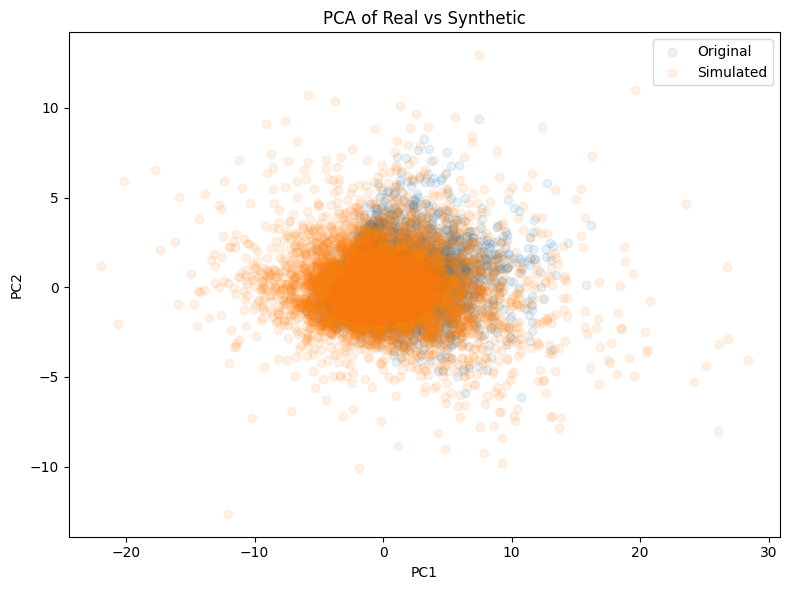

In [201]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# 1) Combine your real & one simulated dataset
combined = pd.concat([original_joint_df, simulated_joint_df], ignore_index=True)
X = combined.drop(columns='source').values
y = combined['source'].values  # array of 'Original' / 'Simulated'

# 2) PCA → 2D
pca = PCA(n_components=2, random_state=2025)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8,6))
for label in ['Original', 'Simulated']:
    idx = (y == label)
    plt.scatter(X_pca[idx,0], X_pca[idx,1], label=label, alpha=0.1)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Real vs Synthetic')
plt.legend()
plt.tight_layout()
plt.show()



In [202]:
# import numpy as np
# import matplotlib.pyplot as plt

# # --- your data as before ---
# # x = np.arange(len(mse_mean))
# # mse_mean, yerr, num_simulations defined above

# # --- pick one Set2 color ---
# cmap = plt.get_cmap('Set2')
# single_color = cmap(0)   # index 2 is the 3rd color in Set2

# # --- plot with that color for every bar ---
# fig, ax = plt.subplots(figsize=(14, 7))
# bars = ax.bar(
#     x, mse_mean,
#     yerr=yerr,
#     capsize=6,
#     width=0.7,
#     color=single_color,
#     edgecolor='white'
# )

# ax.set_facecolor('white')
# fig.patch.set_facecolor('white')
# ax.grid(axis='y', linestyle='--', alpha=0.6)
# for spine in ['top','right','left']:
#     ax.spines[spine].set_visible(False)

# ax.set_xticks(x)
# ax.set_xticklabels(mse_mean.index, rotation=45, ha='right', fontsize=12)
# ax.set_ylabel('Root Mean Squared Error', fontsize=14)
# ax.set_title(
#     f'Baseline Covariates RMSE (90% interval) over {num_simulations} Simulations',
#     fontsize=16, pad=15
# )

# plt.tight_layout()
# plt.show()


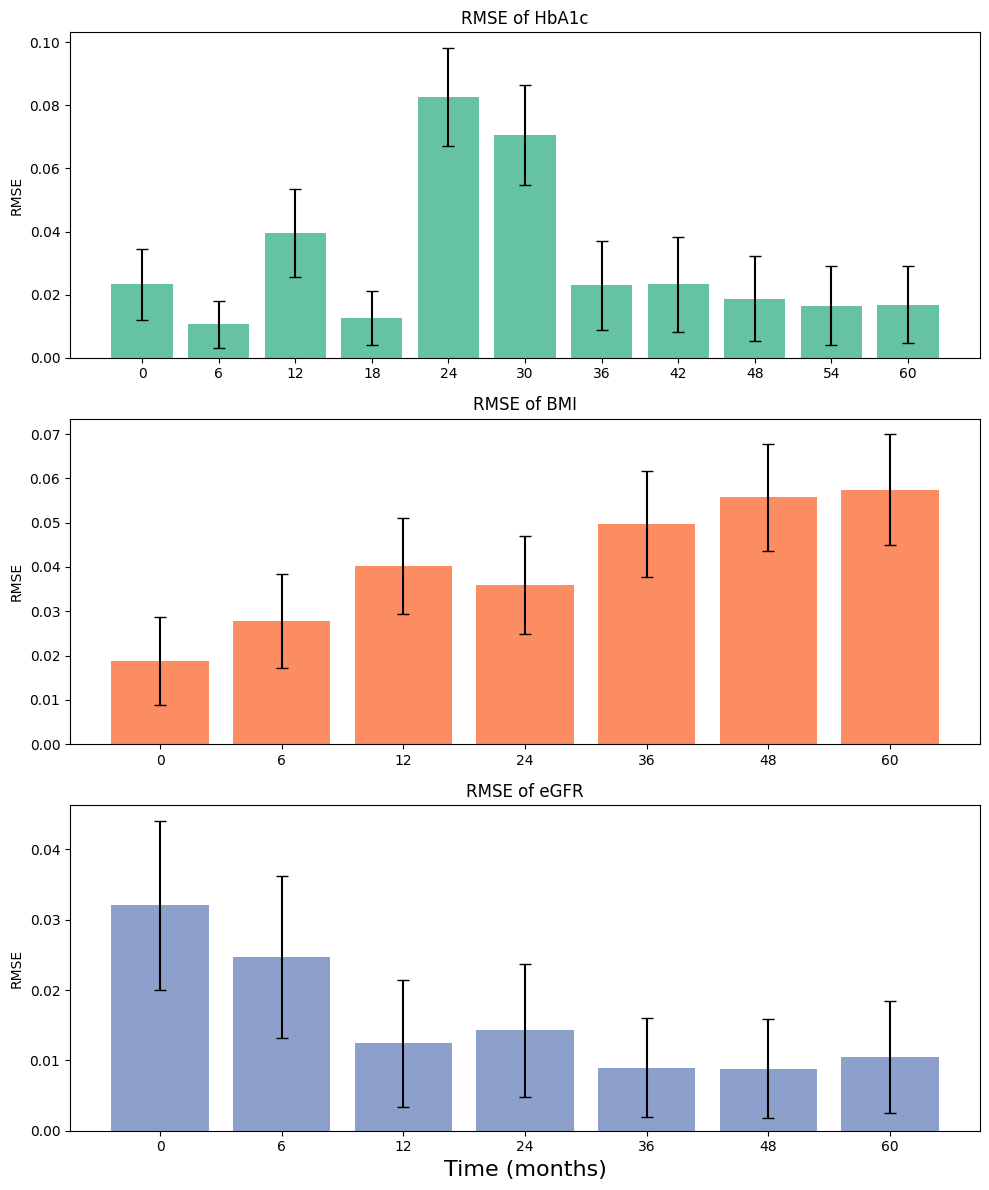

In [203]:
from matplotlib.ticker import FormatStrFormatter
num_samples   = 500                     # MC draws of the joint model
timepoints    = 11
obs_idx       = observed_idx            # [0,1,2,4,6,8,10]
n_obs, z_dim  = z_tensor.shape[0], 3

z1_samples, z2_samples, z3_samples = [], [], []

for _ in range(num_samples):
    # fresh posterior / model draw
    x_sim, s_pred = model_bsl.sample_xz(sample_size=s_tensor.shape[0])
    x_pred, z_pred, y_pred = model.sample_joint(s=s_pred)

    # (2) missing‐impute
    x_pred, z_pred, y_pred = missing_impute(x=x_pred, z=z_pred, y=y_pred, x_dim=1, z_dim=3)


    z_pred_np  = z_pred.reshape(n_obs, timepoints, z_dim).detach().cpu().numpy()

    z1_samples.append(z_pred_np[:, :, 0])        # (n_obs, 11)
    z2_samples.append(z_pred_np[:, obs_idx, 1])  # (n_obs, 7)
    z3_samples.append(z_pred_np[:, obs_idx, 2])  # (n_obs, 7)

z1_samples = np.stack(z1_samples, axis=0)
z2_samples = np.stack(z2_samples, axis=0)
z3_samples = np.stack(z3_samples, axis=0)

z_true_np     = z_tensor.reshape(n_obs, timepoints, z_dim).detach().cpu().numpy()
z1_obs_mean   = z_true_np[:, :, 0].mean(axis=0)         # (11,)
z2_obs_mean   = z_true_np[:, obs_idx, 1].mean(axis=0)   # (7,)
z3_obs_mean   = z_true_np[:, obs_idx, 2].mean(axis=0)   # (7,)


def rmse_per_sample(z_samples, z_mean_obs):
    """Return array (num_samples, T) with RMSE for each MC draw."""
    # squared error of the biomarker *mean* trajectory
    sq_err = (z_samples.mean(axis=1) - z_mean_obs[np.newaxis, :]) ** 2
    return np.sqrt(sq_err)

rmse_z1 = rmse_per_sample(z1_samples, z1_obs_mean)  # (num_samples, 11)
rmse_z2 = rmse_per_sample(z2_samples, z2_obs_mean)  # (num_samples, 7)
rmse_z3 = rmse_per_sample(z3_samples, z3_obs_mean)  # (num_samples, 7)


rmse_stats = {
    'z1': {'mean': rmse_z1.mean(axis=0), 'std': rmse_z1.std(axis=0, ddof=1)},
    'z2': {'mean': rmse_z2.mean(axis=0), 'std': rmse_z2.std(axis=0, ddof=1)},
    'z3': {'mean': rmse_z3.mean(axis=0), 'std': rmse_z3.std(axis=0, ddof=1)},
}


# PLOT 
import matplotlib.pyplot as plt
import seaborn as sns
palette = sns.color_palette("Set2")

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 12), sharex=False)
fig.patch.set_facecolor('white')
for ax in axes:
    ax.set_facecolor('white')
# --- z1 (11 visits) ---
time_z1 = np.arange(timepoints)
axes[0].bar(time_z1,
            rmse_stats['z1']['mean'],
            yerr=rmse_stats['z1']['std'],
            capsize=4, color=palette[0])
axes[0].set_ylabel("RMSE")
axes[0].set_title("RMSE of HbA1c")
axes[0].set_xticks(time_z1, [f"{t}" for t in time_points])
axes[0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# --- z2 (observed visits) ---
time_z2 = np.arange(len(obs_idx))
axes[1].bar(time_z2,
            rmse_stats['z2']['mean'],
            yerr=rmse_stats['z2']['std'],
            capsize=4, color=palette[1])
axes[1].set_ylabel("RMSE")
axes[1].set_title("RMSE of BMI")
axes[1].set_xticks(time_z2, [f"{time_points[i]}" for i in obs_idx])

# --- z3 (observed visits) ---
time_z3 = np.arange(len(obs_idx))
axes[2].bar(time_z3,
            rmse_stats['z3']['mean'],
            yerr=rmse_stats['z3']['std'],
            capsize=4, color=palette[2])
axes[2].set_ylabel("RMSE")
axes[2].set_title("RMSE of eGFR")
axes[2].set_xticks(time_z3, [f"{time_points[i]}" for i in obs_idx])
axes[2].set_xlabel("Time (months)", fontsize=16)    

plt.tight_layout()
plt.show()


In [204]:
import torch
import numpy as np

# --- SETTINGS --------------------------------------------------------------
num_sims = 500
# s_tensor: your N×latent input for units
# x_tensor: original N×T treatment‐history (we'll just use its shape)
N0, T = s_tensor[(x_tensor[:,0]==0),:].shape
N1, T = s_tensor[(x_tensor[:,0]==1),:].shape
# Prepare “pure” control/treatment arms
x_control = torch.zeros((N0, T), dtype=torch.int32)
x_treat   = torch.ones((N1, T), dtype=torch.int32)

control_event_rates = []
treat_event_rates   = []

for _ in range(num_sims):
    # simulate y under control
    y_ctrl = model.sample_causal_margin(
        s=s_tensor[(x_tensor[:,0]==0),:],
        x=x_control,
        sample_size=1
    )
    # simulate y under treatment
    y_trt  = model.sample_causal_margin(
        s=s_tensor[(x_tensor[:,0]==1),:],
        x=x_treat,
        sample_size=1
    )

    # y_ctrl, y_trt assumed shape [N, T] of 0/1’s
    # compute per‐unit “ever an event” indicator
    ever_ctrl = (y_ctrl.sum(dim=1) > 0).float()
    ever_trt  = (y_trt.sum(dim=1) > 0).float()

    # fraction of units with ≥1 event
    control_event_rates.append(ever_ctrl.mean().item())
    treat_event_rates.append( ever_trt.mean().item())



In [205]:
# now summarize
ctrl_min, ctrl_max = np.quantile(control_event_rates, 0.05), np.quantile(control_event_rates,0.95)
trt_min,  trt_max  = np.quantile(treat_event_rates,0.05),   np.quantile(treat_event_rates, 0.95)
ctrl_mean = np.mean(control_event_rates)
trt_mean = np.mean(treat_event_rates)

print(f"Control arm event‐rate over {num_sims} sims: {ctrl_min:.3f}–{ctrl_max:.3f}")
print(f" Treatment arm event‐rate over {num_sims} sims: {trt_min:.3f}–{trt_max:.3f}")
print(ctrl_mean)
print(trt_mean)

Control arm event‐rate over 500 sims: 0.131–0.145
 Treatment arm event‐rate over 500 sims: 0.131–0.145
0.13817919644713403
0.1381744822859764


In [206]:
import torch
import numpy as np

# --- SETTINGS --------------------------------------------------------------
num_sims = 500
# s_tensor: your N×latent input for units
# x_tensor: original N×T treatment‐history (we'll just use its shape)


control_event_rates = []
treat_event_rates   = []

for _ in range(num_sims):
    x,s_pred=model_bsl.sample_xz(sample_size=s_tensor.shape[0])
    N0, T = s_pred[(x[:,0]==0),:].shape
    N1, T = s_pred[(x[:,0]==1),:].shape
    # Prepare “pure” control/treatment arms
    x_control = torch.zeros((N0, T), dtype=torch.int32)
    x_treat   = torch.ones((N1, T), dtype=torch.int32)
    # simulate y under control
    y_ctrl = model.sample_causal_margin(
        s=s_pred[(x[:,0]==0),:],
        x=x_control,
        sample_size=1
    )
    # simulate y under treatment
    y_trt  = model.sample_causal_margin(
        s=s_pred[(x[:,0]==1),:],
        x=x_treat,
        sample_size=1
    )

    # y_ctrl, y_trt assumed shape [N, T] of 0/1’s
    # compute per‐unit “ever an event” indicator
    ever_ctrl = (y_ctrl.sum(dim=1) > 0).float()
    ever_trt  = (y_trt.sum(dim=1) > 0).float()

    # fraction of units with ≥1 event
    control_event_rates.append(ever_ctrl.mean().item())
    treat_event_rates.append( ever_trt.mean().item())



In [207]:
sum(y_ctrl==1)

tensor([  0,  66, 117,  76,  92,  34,  76,  73, 170,   0,   0])

In [208]:
# now summarize
ctrl_min, ctrl_max = np.quantile(control_event_rates, 0.05), np.quantile(control_event_rates,0.95)
trt_min,  trt_max  = np.quantile(treat_event_rates,0.05),   np.quantile(treat_event_rates, 0.95)
ctrl_mean = np.mean(control_event_rates)
trt_mean = np.mean(treat_event_rates)

print(f"Control arm event‐rate over {num_sims} sims: {ctrl_min:.3f}–{ctrl_max:.3f}")
print(f" Treatment arm event‐rate over {num_sims} sims: {trt_min:.3f}–{trt_max:.3f}")
print(ctrl_mean)
print(trt_mean)

Control arm event‐rate over 500 sims: 0.138–0.156
 Treatment arm event‐rate over 500 sims: 0.122–0.139
0.147155043810606
0.13040856581926347


In [190]:
y_ctrl_true = y_tensor[(x_tensor[:,0]==0),:]
y_trt_true = y_tensor[(x_tensor[:,1]==0),:]

ever_ctrl_true = (y_ctrl_true.sum(dim=1) > 0).float()

In [191]:
mask = (arm_values == 1)
y_tr = y_tensor[mask,:]
y_cr = y_tensor[~mask,:]
sum(y_tr==1).sum()/y_tr.shape[0]

tensor(0.1296)

In [192]:
sum(y_cr==1).sum()/y_cr.shape[0]

tensor(0.1471)

# Cox model

In [151]:
import torch
import numpy as np
import pandas as pd
from lifelines import CoxPHFitter

def compute_5yr_risk(y_tensor: torch.Tensor,
                     x_tensor: torch.Tensor,
                     interval_months: int = 6,
                     horizon_months: int = 60):
    """
    y_tensor: shape (N, T=11) with entries {0,1,-1}
              indexed as [0mo, 6mo, 12mo, …, 60mo]
    x_tensor: shape (N,1) treatment {0,1}
    """

    # 1. to numpy
    y = y_tensor.detach().cpu().numpy().astype(int)
    x = x_tensor.detach().cpu().numpy().reshape(-1)
    N, T = y.shape

    # 2. build (duration,event) with correct indexing & censoring
    durations = np.zeros(N, dtype=float)
    events    = np.zeros(N, dtype=int)
    for i in range(N):
        # find first event‐marker
        hits = np.where(y[i] == 1)[0]
        if hits.size > 0:
            # map index k → k*interval_months
            t_event = hits[0] * interval_months
            # if that exceeds 60, treat as censored at 60
            if t_event > horizon_months:
                durations[i] = horizon_months
                events[i]    = 0
            else:
                durations[i] = t_event
                events[i]    = 1
        else:
            # no events → censored at 60
            durations[i] = horizon_months
            events[i]    = 0

    # 3. fit Cox(treatment)
    df = pd.DataFrame({
        "time":      durations,
        "event":     events,
        "treatment": x
    })
    cph = CoxPHFitter()
    cph.fit(df, duration_col="time", event_col="event", formula="treatment")

    # 4. survival@60 → absolute risk
    sf0 = cph.predict_survival_function(
            pd.DataFrame({"treatment": [0]}),
            times=[horizon_months]
         ).iloc[0,0]
    sf1 = cph.predict_survival_function(
            pd.DataFrame({"treatment": [1]}),
            times=[horizon_months]
         ).iloc[0,0]
    risk0 = 1 - sf0
    risk1 = 1 - sf1

    return {
        "cph_summary":   cph.summary,
        "hazard_ratio":  np.exp(cph.params_["treatment"]),
        "risk_control":  risk0,
        "risk_treatment":risk1
    }

# --- USAGE on your real data ---

# make sure x_tensor is (N,1), not (N,)
x = x_tensor[:,0].reshape(-1,1)
res_real = compute_5yr_risk(y_tensor, x)

print("=== Real data Cox(treatment) ===")
print(res_real["cph_summary"])
print(f"HR(treat vs ctrl)   = {res_real['hazard_ratio']:.3f}")
print(f"5-yr risk (control) = {res_real['risk_control']:.1%}")
print(f"5-yr risk (treatment)= {res_real['risk_treatment']:.1%}")


=== Real data Cox(treatment) ===
               coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                  
treatment -0.121454   0.885632  0.058609       -0.236325       -0.006582   

           exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                               
treatment             0.789524             0.993439     0.0 -2.072275   

                 p  -log2(p)  
covariate                     
treatment  0.03824  4.708783  
HR(treat vs ctrl)   = 0.886
5-yr risk (control) = 14.0%
5-yr risk (treatment)= 12.5%


In [152]:
import torch
import numpy as np
import pandas as pd
from lifelines import CoxPHFitter

def compute_5yr_stats_iter(y_tensor: torch.Tensor,
                      x_tensor: torch.Tensor,
                      interval_months: int = 6,
                      horizon_months: int = 60):
    # (1) to numpy
    y = y_tensor.detach().cpu().numpy().astype(int)
    x = x_tensor.detach().cpu().numpy().reshape(-1)
    N, T = y.shape

    # (2) build (duration,event)
    durations = np.zeros(N, dtype=float)
    events    = np.zeros(N, dtype=int)
    for i in range(N):
        hits = np.where(y[i] == 1)[0]
        if hits.size:
            durations[i] = (hits[0] + 1) * interval_months
            events[i]    = 1
        else:
            durations[i] = horizon_months
            events[i]    = 0

    # (3) fit Cox
    df = pd.DataFrame({
        "time":      durations,
        "event":     events,
        "treatment": x
    })
    cph = CoxPHFitter()
    cph.fit(df, duration_col="time", event_col="event", formula="treatment")

    # (4) 5-yr survival → absolute risk
    sf0 = cph.predict_survival_function(
            pd.DataFrame({"treatment":[0]}),
            times=[horizon_months]
          ).iloc[0,0]
    sf1 = cph.predict_survival_function(
            pd.DataFrame({"treatment":[1]}),
            times=[horizon_months]
          ).iloc[0,0]
    risk0 = 1 - sf0
    risk1 = 1 - sf1

    # (5) extract log-HR and its 95% CI from summary
    summ     = cph.summary.loc["treatment"]
    coef     = summ["coef"]
    ci_lower = summ["coef lower 95%"]
    ci_upper = summ["coef upper 95%"]
    p = summ['p']

    return risk0, risk1, coef, ci_lower, ci_upper,p

# ------------------------------------------------------------------------
# now run your 5,000 sims, collect everything
num_sims = 5000

risk_ctrl_sims = []
risk_trt_sims  = []
coef_sims      = []
ci_lower_sims  = []
ci_upper_sims  = []
p_sims=[]

for _ in range(num_sims):
    # draw latent & x-histories
    x_hist, s_pred = model_bsl.sample_xz(sample_size=s_tensor.shape[0])

    # split for ctrl vs treatment
    mask0 = (x_hist[:,0] == 0)
    mask1 = (x_hist[:,0] == 1)
    N0 = mask0.sum().item()
    N1 = mask1.sum().item()
    T  = y_tensor.shape[1]

    # pure-arm x histories (we only need first column for covariate)
    x0 = torch.zeros((N0, T), dtype=torch.int32)
    x1 = torch.ones ((N1, T), dtype=torch.int32)

    # simulate y under each arm
    y0 = model.sample_causal_margin(s=s_pred[mask0], x=x0, sample_size=1)
    y1 = model.sample_causal_margin(s=s_pred[mask1], x=x1, sample_size=1)

    # stack into one big dataset
    y_sim = torch.cat([y0, y1], dim=0)                  # shape (N0+N1, T)
    x_sim = torch.cat([x0, x1], dim=0)[:, :1].float()    # shape (N0+N1, 1)

    # compute and collect
    r0, r1, coef, lo, hi,p = compute_5yr_stats_iter(y_sim, x_sim)
    risk_ctrl_sims.append(r0)
    risk_trt_sims.append(r1)
    coef_sims.append(coef)
    ci_lower_sims.append(lo)
    ci_upper_sims.append(hi)
    p_sims.append(p)



In [153]:
# ------------------------------------------------------------------------
# convert to arrays and summarize
risk_ctrl_sims = np.array(risk_ctrl_sims)
risk_trt_sims  = np.array(risk_trt_sims)
coef_sims      = np.array(coef_sims)
ci_lower_sims  = np.array(ci_lower_sims)
ci_upper_sims  = np.array(ci_upper_sims)
p_sims = np.array(p_sims)
print("=== 5-year absolute risks over sims ===")
print(f"Control : mean={risk_ctrl_sims.mean():.3%}, sd={risk_ctrl_sims.std(ddof=1):.3%}")
print(f"Treatment: mean={risk_trt_sims.mean():.3%}, sd={risk_trt_sims.std(ddof=1):.3%}")

print("\n=== Treatment coefficient (log-HR) over sims ===")
print(f"Coef     : mean={coef_sims.mean():.3f}, sd={coef_sims.std(ddof=1):.3f}")
print(f"CI lower : mean={ci_lower_sims.mean():.3f}, sd={ci_lower_sims.std(ddof=1):.3f}")
print(f"CI upper : mean={ci_upper_sims.mean():.3f}, sd={ci_upper_sims.std(ddof=1):.3f}")

=== 5-year absolute risks over sims ===
Control : mean=14.205%, sd=0.509%
Treatment: mean=12.811%, sd=0.505%

=== Treatment coefficient (log-HR) over sims ===
Coef     : mean=-0.111, sd=0.057
CI lower : mean=-0.225, sd=0.058
CI upper : mean=0.003, sd=0.057


In [148]:
import torch
import numpy as np
import pandas as pd
from lifelines import CoxPHFitter

def compute_5yr_stats_iter(y_tensor: torch.Tensor,
                      x_tensor: torch.Tensor,
                      interval_months: int = 6,
                      horizon_months: int = 60):
    # (1) to numpy
    y = y_tensor.detach().cpu().numpy().astype(int)
    x = x_tensor.detach().cpu().numpy().reshape(-1)
    N, T = y.shape

    # (2) build (duration,event)
    durations = np.zeros(N, dtype=float)
    events    = np.zeros(N, dtype=int)
    for i in range(N):
        hits = np.where(y[i] == 1)[0]
        if hits.size:
            durations[i] = (hits[0] + 1) * interval_months
            events[i]    = 1
        else:
            durations[i] = horizon_months
            events[i]    = 0

    # (3) fit Cox
    df = pd.DataFrame({
        "time":      durations,
        "event":     events,
        "treatment": x
    })
    cph = CoxPHFitter()
    cph.fit(df, duration_col="time", event_col="event", formula="treatment")

    # (4) 5-yr survival → absolute risk
    sf0 = cph.predict_survival_function(
            pd.DataFrame({"treatment":[0]}),
            times=[horizon_months]
          ).iloc[0,0]
    sf1 = cph.predict_survival_function(
            pd.DataFrame({"treatment":[1]}),
            times=[horizon_months]
          ).iloc[0,0]
    risk0 = 1 - sf0
    risk1 = 1 - sf1

    # (5) extract log-HR and its 95% CI from summary
    summ     = cph.summary.loc["treatment"]
    coef     = summ["coef"]
    ci_lower = summ["coef lower 95%"]
    ci_upper = summ["coef upper 95%"]
    p = summ['p']

    return risk0, risk1, coef, ci_lower, ci_upper,p

# ------------------------------------------------------------------------
# now run your 5,000 sims, collect everything
num_sims = 5000

risk_ctrl_sims = []
risk_trt_sims  = []
coef_sims      = []
ci_lower_sims  = []
ci_upper_sims  = []
p_sims=[]

for _ in range(num_sims):
    # draw latent & x-histories
    # x_hist, s_pred = model_bsl.sample_xz(sample_size=s_tensor.shape[0])

    # split for ctrl vs treatment
    mask0 = (x_tensor[:,0] == 0)
    mask1 = (x_tensor[:,0] == 1)
    N0 = mask0.sum().item()
    N1 = mask1.sum().item()
    T  = y_tensor.shape[1]

    # pure-arm x histories (we only need first column for covariate)
    x0 = torch.zeros((N0, T), dtype=torch.int32)
    x1 = torch.ones ((N1, T), dtype=torch.int32)

    # simulate y under each arm
    y0 = model.sample_causal_margin(s=s_tensor[mask0], x=x0, sample_size=1)
    y1 = model.sample_causal_margin(s=s_tensor[mask1], x=x1, sample_size=1)

    # stack into one big dataset
    y_sim = torch.cat([y0, y1], dim=0)                  # shape (N0+N1, T)
    x_sim = torch.cat([x0, x1], dim=0)[:, :1].float()    # shape (N0+N1, 1)

    # compute and collect
    r0, r1, coef, lo, hi,p = compute_5yr_stats_iter(y_sim, x_sim)
    risk_ctrl_sims.append(r0)
    risk_trt_sims.append(r1)
    coef_sims.append(coef)
    ci_lower_sims.append(lo)
    ci_upper_sims.append(hi)
    p_sims.append(p)

# ------------------------------------------------------------------------
# convert to arrays and summarize
risk_ctrl_sims = np.array(risk_ctrl_sims)
risk_trt_sims  = np.array(risk_trt_sims)
coef_sims      = np.array(coef_sims)
ci_lower_sims  = np.array(ci_lower_sims)
ci_upper_sims  = np.array(ci_upper_sims)
p_sims = np.array(p_sims)
print("=== 5-year absolute risks over sims ===")
print(f"Control : mean={risk_ctrl_sims.mean():.3%}, sd={risk_ctrl_sims.std(ddof=1):.3%}")
print(f"Treatment: mean={risk_trt_sims.mean():.3%}, sd={risk_trt_sims.std(ddof=1):.3%}")

print("\n=== Treatment coefficient (log-HR) over sims ===")
print(f"Coef     : mean={coef_sims.mean():.3f}, sd={coef_sims.std(ddof=1):.3f}")
print(f"CI lower : mean={ci_lower_sims.mean():.3f}, sd={ci_lower_sims.std(ddof=1):.3f}")
print(f"CI upper : mean={ci_upper_sims.mean():.3f}, sd={ci_upper_sims.std(ddof=1):.3f}")

=== 5-year absolute risks over sims ===
Control : mean=14.079%, sd=0.511%
Treatment: mean=12.761%, sd=0.500%

=== Treatment coefficient (log-HR) over sims ===
Coef     : mean=-0.106, sd=0.058
CI lower : mean=-0.220, sd=0.059
CI upper : mean=0.008, sd=0.058
